# Plant disease recognition

## Imports of external libraries

### Downloading the libraries

To download the required libraries, run the following command line:
```bash
pip install -r requirements.txt
```

### Importing the libraries

In [ ]:
import numpy as np
import kagglehub
import pickle
import cv2

from os import listdir
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/vectra/code/code/ML-Project/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-17 15:13:12.756020: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 15:13:12.790269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 15:13:13.479048: I tensorflow/core/util/port.cc:153] oneDNN custom operations a

### Cuda implementation

In [2]:
# Force TensorFlow to find CUDA libraries - run BEFORE importing tensorflow
import os
import glob

# Find CUDA installations
cuda_candidates = [
    '/usr/local/cuda*/lib64',
    '/usr/lib/x86_64-linux-gnu',  # system CUDA on Ubuntu
    '/opt/cuda*/lib64',
    os.path.expanduser('~/.local/cuda*/lib64'),
]

cuda_libs = []
for pattern in cuda_candidates:
    cuda_libs.extend(glob.glob(pattern))

# Also check conda env if active
conda_prefix = os.environ.get('CONDA_PREFIX', '')
if conda_prefix:
    cuda_libs.append(os.path.join(conda_prefix, 'lib'))

# Filter to directories that exist
cuda_libs = [p for p in cuda_libs if os.path.isdir(p)]
print(f"Found CUDA library paths: {cuda_libs}")

# Prepend to LD_LIBRARY_PATH
existing_ld = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = ':'.join(cuda_libs) + ':' + existing_ld
print(f"LD_LIBRARY_PATH updated (first 300 chars): {os.environ['LD_LIBRARY_PATH'][:300]}...")

# CRITICAL: This must run BEFORE importing tensorflow for the first time
# If you already imported tensorflow above, restart the kernel!

Found CUDA library paths: []
LD_LIBRARY_PATH updated (first 300 chars): :/home/vectra/code/code/ML-Project/env/lib/python3.13/site-packages/cv2/../../lib64:...


In [3]:
gpus = tensorflow.config.list_physical_devices('GPU')
print('GPUs:', gpus)
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        print('Enabled memory growth for GPUs')
    except Exception as e:
        print('Could not set memory growth:', e)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Enabled memory growth for GPUs


In [4]:
# Detailed GPU diagnostics
print("TensorFlow version:", tensorflow.__version__)
print("Built with CUDA:", tensorflow.test.is_built_with_cuda())
print("GPU available:", tensorflow.test.is_gpu_available())  # deprecated but helpful
print("\nPhysical devices:")
for device in tensorflow.config.list_physical_devices():
    print(f"  {device}")
print("\nGPU devices:")
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu}")
        details = tensorflow.config.experimental.get_device_details(gpu)
        print(f"    Details: {details}")
else:
    print("  No GPUs detected by TensorFlow")
    print("\nPossible issues:")
    print("  1. CUDA/cuDNN not installed or version mismatch")
    print("  2. tensorflow-gpu not installed (TF 2.x should auto-detect)")
    print("  3. GPU drivers not loaded")
    print("  4. Check: nvidia-smi in terminal")

TensorFlow version: 2.20.0
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True

Physical devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU devices:
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
    Details: {'compute_capability': (8, 9), 'device_name': 'NVIDIA GeForce RTX 4070 Laptop GPU'}


I0000 00:00:1763410394.644050   70604 gpu_device.cc:2020] Created device /device:GPU:0 with 6107 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Debug: Check what CUDA libraries TensorFlow can see
import os
import ctypes.util

print("Checking for CUDA libraries that TensorFlow needs:")
cuda_libs = ['cudart', 'cublas', 'cufft', 'curand', 'cusolver', 'cusparse', 'cudnn']
for lib in cuda_libs:
    path = ctypes.util.find_library(lib)
    if path:
        print(f"  ✓ {lib}: {path}")
    else:
        print(f"  ✗ {lib}: NOT FOUND")
        
print("\nCurrent LD_LIBRARY_PATH:")
print(os.environ.get('LD_LIBRARY_PATH', '(not set)'))

Checking for CUDA libraries that TensorFlow needs:
  ✗ cudart: NOT FOUND
  ✗ cublas: NOT FOUND
  ✗ cufft: NOT FOUND
  ✗ curand: NOT FOUND
  ✗ cusolver: NOT FOUND
  ✗ cusparse: NOT FOUND
  ✗ cudnn: NOT FOUND

Current LD_LIBRARY_PATH:
:/home/vectra/code/code/ML-Project/env/lib/python3.13/site-packages/cv2/../../lib64:


## Downloading the dataset

In [6]:
path = kagglehub.dataset_download("emmarex/plantdisease")

100%|██████████| 658M/658M [01:42<00:00, 6.71MB/s] 

Extracting files...


## Setting the parameters

In [7]:
EPOCHS             = 25
INIT_LR            = 1e-3
BS                 = 16
WIDTH              = 256
HEIGHT             = 256
DEFAULT_IMAGE_SIZE = tuple((WIDTH, HEIGHT))
IMAGE_SIZE         = 0
DIRECTORY_ROOT     = path+'/plantvillage/'
DEPTH              = 3

## Preprocessing the images

In [8]:
from pathlib import Path
from collections import defaultdict

# Sanity-check the dataset root
_dr = Path(DIRECTORY_ROOT).resolve()
print(f"[INFO] DIRECTORY_ROOT = {_dr}")
print(f"[INFO] Exists: {_dr.exists()}  Is dir: {_dr.is_dir()}")

if _dr.exists() and _dr.is_dir():
    subdirs = [p for p in _dr.iterdir() if p.is_dir()]
    print(f"[INFO] Top-level subfolders: {len(subdirs)}")
    # Show a few subfolders and quick image counts
    exts = {'.jpg', '.jpeg', '.png', '.bmp'}
    for p in sorted(subdirs)[:8]:
        try:
            files = [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in exts]
            print(f" - {p.name}: {len(files)} images directly inside")
        except Exception as e:
            print(f" - {p.name}: [WARN] error listing -> {e}")
else:
    print("[WARN] DIRECTORY_ROOT missing or not a folder. Verify dataset download path.")

[INFO] DIRECTORY_ROOT = /home/vectra/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage
[INFO] Exists: True  Is dir: True
[INFO] Top-level subfolders: 1
 - PlantVillage: 0 images directly inside


### Image conversion in usable data (np arrays)

[INFO] Loading images ...
[INFO] Detected 15 class folders.

[INFO] Image loading completed.
[INFO] Per-class counts (capped):
 - Pepper__bell___Bacterial_spot: 300
 - Pepper__bell___healthy: 300
 - Potato___Early_blight: 300
 - Potato___Late_blight: 300
 - Potato___healthy: 152
 - Tomato_Bacterial_spot: 300
 - Tomato_Early_blight: 300
 - Tomato_Late_blight: 300
 - Tomato_Leaf_Mold: 300
 - Tomato_Septoria_leaf_spot: 300
 - Tomato_Spider_mites_Two_spotted_spider_mite: 300
 - Tomato__Target_Spot: 300
 - Tomato__Tomato_YellowLeaf__Curl_Virus: 300
 - Tomato__Tomato_mosaic_virus: 300
 - Tomato_healthy: 300

[INFO] Total images loaded: 4352
[INFO] Total labels loaded: 4352

[INFO] Display of the overall distribution of the classes...


/tmp/ipykernel_70604/1157984244.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=counts, palette="viridis")


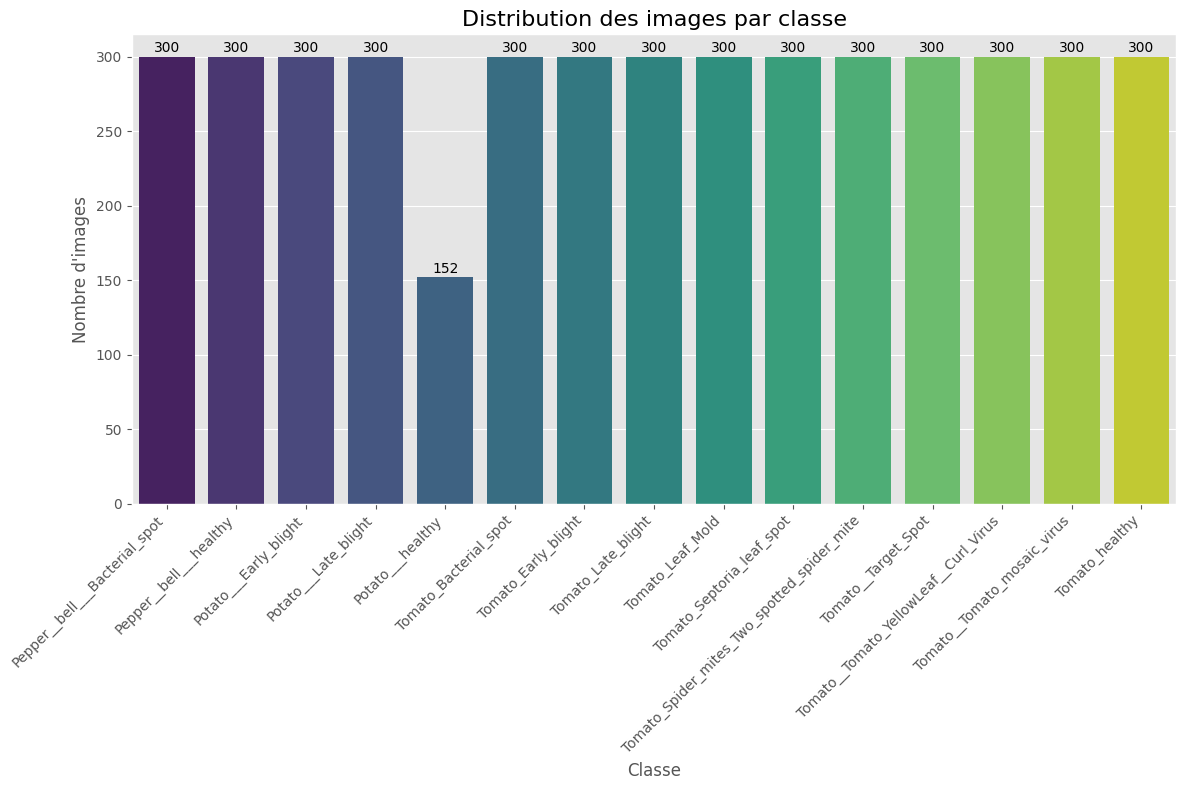

In [ ]:
from pathlib import Path
import cv2
import numpy as np
from keras.utils import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

# === Constants and Configuration ===
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
MAX_PER_CLASS = 10000  # to keep a cap similar to your previous sampling

# === Core Functions ===

def convert_image_to_array(image_dir):
    """Reads, resizes, and converts an image to a NumPy array."""
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            print(f"[WARNING] Could not read image: {image_dir}. Skipping.")
            return np.array([])
    except Exception as e:
        print(f"Error processing {image_dir}: {e}")
        return None


def _find_class_dirs(root: Path):
    """
    Recursively finds directories containing images to be treated as classes.
    Handles both direct class folders and one level of nesting.
    """
    class_dirs = []
    for p in root.iterdir():
        if not p.is_dir():
            continue
        # Case 1: class folders exist directly under root
        try:
            if any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in p.iterdir()):
                class_dirs.append(p)
                continue
        except Exception:
            pass # Ignore permission errors etc.

        # Case 2: there's an extra grouping level (e.g., color/segmented -> classes)
        try:
            for sub in p.iterdir():
                if sub.is_dir():
                    if any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in sub.iterdir()):
                        class_dirs.append(sub)
        except Exception:
            pass
    # Deduplicate and sort by name for consistent ordering
    return sorted(list(set(class_dirs)), key=lambda x: x.name)

def plot_class_distribution(class_counts: dict):
    """
    Generates and displays a bar chart of the number of images per class.
    """
    if not class_counts:
        print("[INFO] No data available to plot.")
        return

    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))
    
    # Create bar plot
    ax = sns.barplot(x=labels, y=counts, palette="viridis")
    
    # Add titles and labels for clarity
    ax.set_title("Distribution des images par classe", fontsize=16)
    ax.set_xlabel("Classe", fontsize=12)
    ax.set_ylabel("Nombre d'images", fontsize=12)
    
    # Rotate labels on the x-axis to prevent overlap
    plt.xticks(rotation=45, ha='right')
    
    # Add the count number on top of each bar
    for index, value in enumerate(counts):
        plt.text(index, value + (max(counts)*0.01), str(value), ha='center')

    # Ensure everything fits without being cut off
    plt.tight_layout()
    
    # Display the plot
    print("\n[INFO] Display of the overall distribution of the classes...")
    plt.show()


# === Main Execution Logic ===
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root = Path(DIRECTORY_ROOT)
    if not root.exists() or not root.is_dir():
        raise FileNotFoundError(f"Dataset root not found: {root}")

    class_dirs = _find_class_dirs(root)
    if not class_dirs:
        raise FileNotFoundError(f"No class directories with images found in {root}")
    print(f"[INFO] Detected {len(class_dirs)} class folders.")

    per_class_counts = {}
    for cdir in class_dirs:
        try:
            # List, sort, and cap the number of files
            files = sorted([f for f in cdir.iterdir() if f.is_file() and f.suffix.lower() in ALLOWED_EXTS])[:MAX_PER_CLASS]
            per_class_counts[cdir.name] = len(files)

            for fp in files:
                arr = convert_image_to_array(str(fp))
                if arr is not None and arr.size > 0:
                    image_list.append(arr)
                    label_list.append(cdir.name)
        except Exception as e:
            print(f"[ERROR] Could not process directory {cdir.name}: {e}")


    print("\n[INFO] Image loading completed.")
    print("[INFO] Per-class counts (capped):")
    for k, v in sorted(per_class_counts.items()):
        print(f" - {k}: {v}")
    print(f"\n[INFO] Total images loaded: {len(image_list)}")
    print(f"[INFO] Total labels loaded: {len(label_list)}")

    # --- VISUALIZATION ---
    plot_class_distribution(per_class_counts)

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
IMAGE_SIZE = len(image_list)



### Splitting images between training and testing set (Part 1)


Class distribution in 'Total Dataset':
  Pepper__bell___Bacterial_spot : 300 (6.89%)
  Pepper__bell___healthy : 300 (6.89%)
  Potato___Early_blight : 300 (6.89%)
  Potato___Late_blight : 300 (6.89%)
  Potato___healthy : 152 (3.49%)
  Tomato_Bacterial_spot : 300 (6.89%)
  Tomato_Early_blight : 300 (6.89%)
  Tomato_Late_blight : 300 (6.89%)
  Tomato_Leaf_Mold : 300 (6.89%)
  Tomato_Septoria_leaf_spot : 300 (6.89%)
  Tomato_Spider_mites_Two_spotted_spider_mite : 300 (6.89%)
  Tomato__Target_Spot : 300 (6.89%)
  Tomato__Tomato_YellowLeaf__Curl_Virus : 300 (6.89%)
  Tomato__Tomato_mosaic_virus : 300 (6.89%)
  Tomato_healthy : 300 (6.89%)

Class distribution in 'Train Set':
  Pepper__bell___Bacterial_spot : 240 (6.89%)
  Pepper__bell___healthy : 240 (6.89%)
  Potato___Early_blight : 240 (6.89%)
  Potato___Late_blight : 240 (6.89%)
  Potato___healthy : 121 (3.48%)
  Tomato_Bacterial_spot : 240 (6.89%)
  Tomato_Early_blight : 240 (6.89%)
  Tomato_Late_blight : 240 (6.89%)
  Tomato_Leaf_Mold :

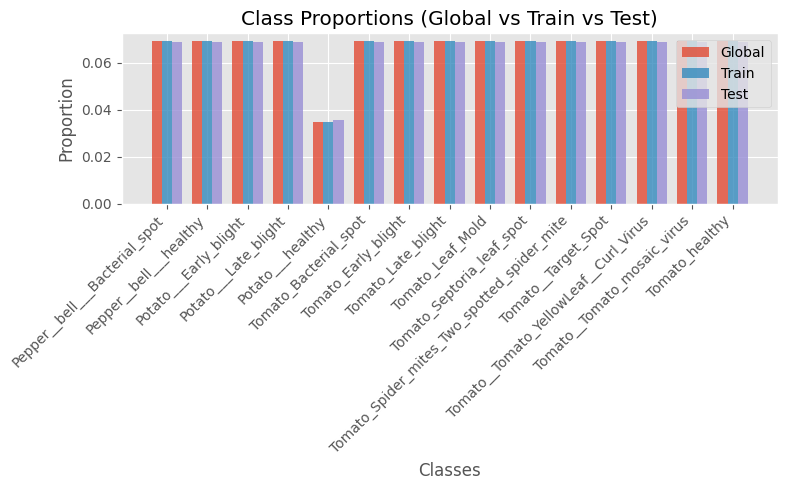

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, List


def print_class_distribution(labels: np.ndarray, name: str = "Dataset") -> Tuple[np.ndarray, np.ndarray]:
    """
    Print the distribution of classes in a dataset.
    
    Args:
        labels (np.ndarray): Array of class labels.
        name (str): Name of the dataset (for printing purposes).
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Unique classes and their counts.
    """
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nClass distribution in '{name}':")
    for cls, count in zip(unique, counts):
        print(f"  {cls} : {count} ({count / len(labels) * 100:.2f}%)")
    return unique, counts


def plot_class_distribution(
    global_counts: np.ndarray,
    train_counts: np.ndarray,
    test_counts: np.ndarray,
    categories: np.ndarray,
    figsize: Tuple[int, int] = (8, 5)
) -> None:
    """
    Plot class distributions for the global dataset, training set, and test set.
    
    Args:
        global_counts (np.ndarray): Counts of each class in the full dataset.
        train_counts (np.ndarray): Counts of each class in the training set.
        test_counts (np.ndarray): Counts of each class in the test set.
        categories (np.ndarray): Array of class names.
        figsize (Tuple[int, int]): Size of the matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Compute proportions
    global_props = global_counts / global_counts.sum()
    train_props = train_counts / train_counts.sum()
    test_props = test_counts / test_counts.sum()
    
    # Bar positions
    x = np.arange(len(categories))
    width = 0.25
    
    # Plot bars
    ax.bar(x - width, global_props, width, label='Global', alpha=0.8)
    ax.bar(x, train_props, width, label='Train', alpha=0.8)
    ax.bar(x + width, test_props, width, label='Test', alpha=0.8)
    
    # Labels & title
    ax.set_xlabel("Classes")
    ax.set_ylabel("Proportion")
    ax.set_title("Class Proportions (Global vs Train vs Test)")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


# === Main Execution Logic for Stratified Split and Visualization ===
labels_np = np.array(label_list)
idx = np.arange(len(labels_np))

# Stratified split
train_idx, test_idx = train_test_split(
    idx, 
    test_size=0.2, 
    random_state=42, stratify=labels_np
)

# Print distributions
categories, global_counts = print_class_distribution(labels_np, name="Total Dataset")
_, train_counts = print_class_distribution(labels_np[train_idx], name="Train Set")
_, test_counts = print_class_distribution(labels_np[test_idx], name="Test Set")

# Plot distributions
plot_class_distribution(global_counts, train_counts, test_counts, categories)




### Model's classes binarization (label's vectorization)

In [12]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(labels_np[train_idx])
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
import pickle
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


### Splitting images between training and testing set (Part 2)

In [13]:
np_image_list = np.array(image_list, dtype=np.float32) / 255.0
print("[INFO] Splitting data to train, test (stratified)")
x_train = np_image_list[train_idx]
x_test = np_image_list[test_idx]
y_train = label_binarizer.transform(labels_np[train_idx])
y_test = label_binarizer.transform(labels_np[test_idx])
print(f"Train: {x_train.shape}, Test: {x_test.shape}, Classes: {n_classes}")

[INFO] Splitting data to train, test (stratified)
Train: (3481, 256, 256, 3), Test: (871, 256, 256, 3), Classes: 15


## Building the model

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1
    
# First Conv Block
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# Second Conv Block
model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Conv Block
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth Conv Block
#model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# Use global pooling instead of flatten to avoid huge dense weight matrices
model.add(Flatten())
model.add(Dense(252, kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, kernel_regularizer=l2(1e-4)))
model.add(Activation("softmax"))

model.summary()

/home/vectra/code/code/ML-Project/env/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 316,735 (1.21 MB)

 Trainable params: 315,399 (1.20 MB)

 Non-trainable params: 1,336 (5.22 KB)

In [24]:
opt = Adam(learning_rate=INIT_LR)
# For single-label multi-class classification, use categorical_crossentropy with mild label smoothing
loss = tensorflow.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
]

In [26]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [27]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/25


2025-11-17 15:24:05.123300: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2955', 4 bytes spill stores, 4 bytes spill loads

2025-11-17 15:24:05.263269: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3651', 4 bytes spill stores, 4 bytes spill loads

2025-11-17 15:24:05.287020: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3651', 8 bytes spill stores, 8 bytes spill loads



218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3037 - loss: 2.6909

2025-11-17 15:24:31.397087: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:24:31.581253: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_319', 4 bytes spill stores, 4 bytes spill loads



218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.3895 - loss: 2.3587 - val_accuracy: 0.1183 - val_loss: 5.8104 - learning_rate: 0.0010
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.5280 - loss: 1.8715 - val_accuracy: 0.3410 - val_loss: 2.9008 - learning_rate: 0.0010
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.6093 - loss: 1.6477 - val_accuracy: 0.4202 - val_loss: 2.6191 - learning_rate: 0.0010
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.6607 - loss: 1.5158 - val_accuracy: 0.4558 - val_loss: 2.5753 - learning_rate: 0.0010
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.6688 - loss: 1.4606 - val_accuracy: 0.4374 - val_loss: 2.9325 - learning_rate: 0.0010
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.6903 - loss: 1.4283 - val_accuracy: 0.5637 - val_loss: 1.8494 - learning_rate: 0.0010
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7320 - loss: 1.31

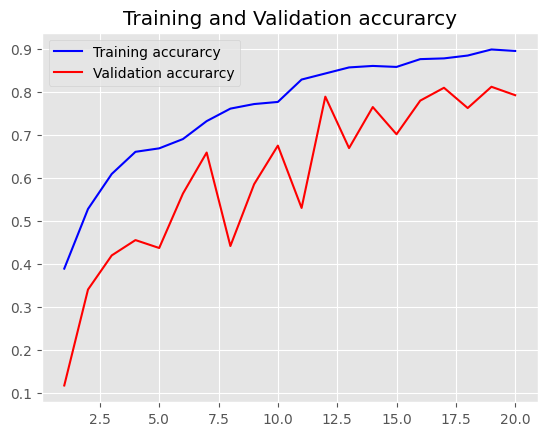

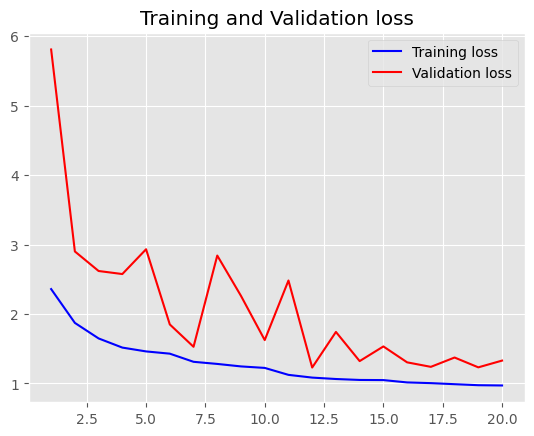

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

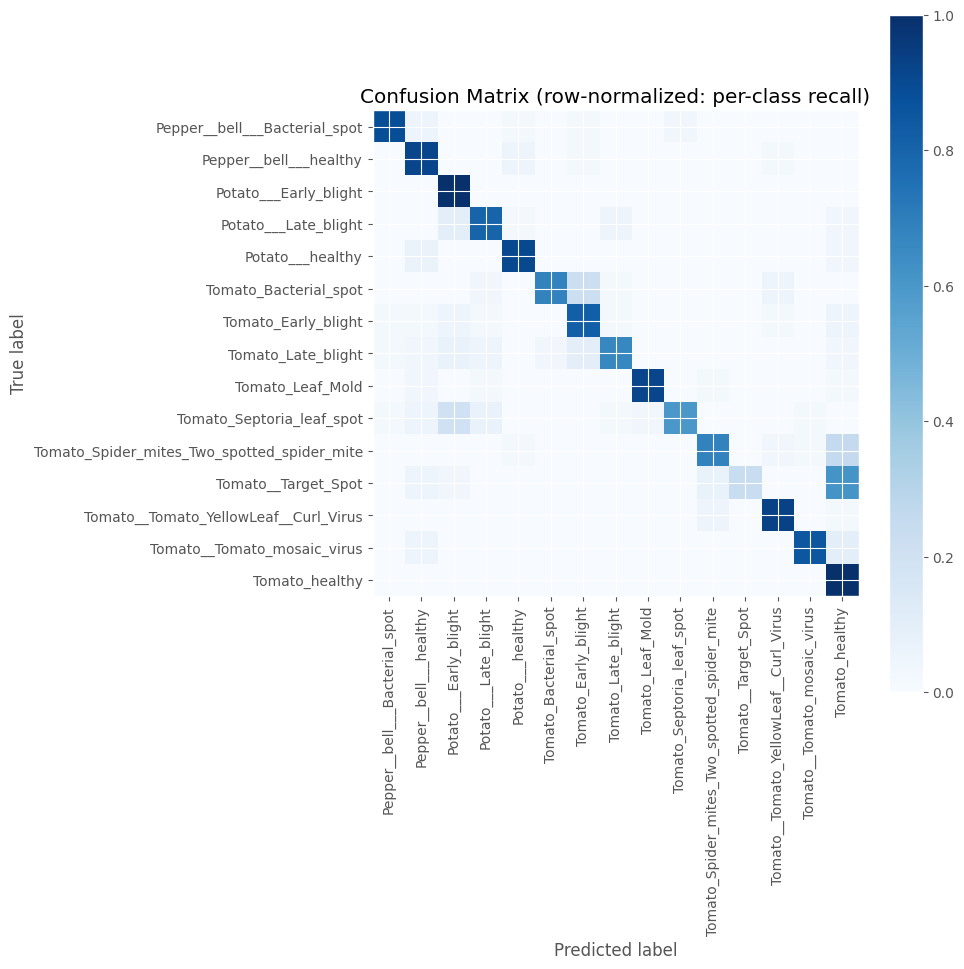

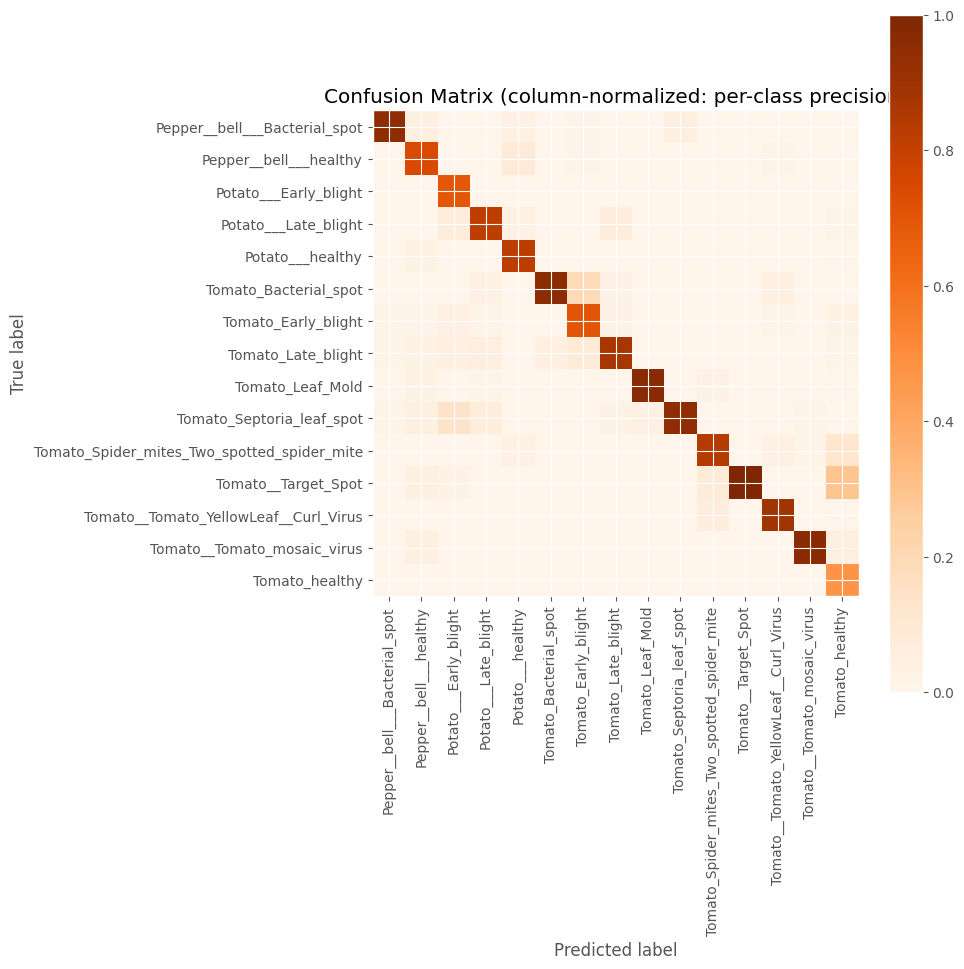

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot      0.946     0.883     0.914        60
                     Pepper__bell___healthy      0.743     0.917     0.821        60
                      Potato___Early_blight      0.690     1.000     0.816        60
                       Potato___Late_blight      0.814     0.800     0.807        60
                           Potato___healthy      0.824     0.903     0.862        31
                      Tomato_Bacterial_spot      0.953     0.683     0.796        60
                        Tomato_Early_blight      0.700     0.817     0.754        60
                         Tomato_Late_blight      0.870     0.667     0.755        60
                           Tomato_Leaf_Mold      0.965     0.917     0.940        60
                  Tomato_Septoria_leaf_spot      0.947     0.600     0.735        60
Tomato_Spider_mites_Two_spotted_spider_mite      0.837     0.683

In [29]:
# Confusion matrix and classification report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# If y_test is one-hot encoded, convert to class indices
y_true = np.argmax(y_test, axis=1)
# Predict class indices
probs = model.predict(x_test, batch_size=BS, verbose=0)
y_pred = np.argmax(probs, axis=1)

labels = list(label_binarizer.classes_)
num_classes = len(labels)

# Normalized by true labels (each row sums to 1): highlights recall per class
cm_true = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="true")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_true, display_labels=labels)
disp.plot(include_values=False, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (row-normalized: per-class recall)")
plt.tight_layout()
plt.show()

# Optional: also view prediction-normalized (each column sums to 1): highlights precision per class
cm_pred = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="pred")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_pred, display_labels=labels)
disp.plot(include_values=False, cmap="Oranges", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (column-normalized: per-class precision)")
plt.tight_layout()
plt.show()

# Full per-class metrics
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# Identify most confused pairs (off-diagonal)
cm_off = cm_true.copy()
np.fill_diagonal(cm_off, 0.0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]
top_k = 10
print("\nTop confused class pairs (true → predicted) with rates:")
for i, j in pairs[:top_k]:
    if cm_off[i, j] > 0:
        print(f" - {labels[i]} → {labels[j]}: {cm_off[i, j]:.3f}")

In [30]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7887 - loss: 1.2286
Test Accuracy: 78.8748562335968


In [31]:
# save the model to disk
#print("[INFO] Saving model...")
#model.save('cnn_2.keras')